# Sentiment Analysis Preprocessing & Baseline Modeling

Building on EDA with NER-aware feature extraction, stopword removal, lemmatization, and baseline sentiment classification for Spotify reviews.

In [11]:
import pandas as pd
import numpy as np
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Load data from previous EDA
df = pd.read_csv('../Data/spotify_reviews.csv')

# Re-apply preprocessing from EDA
import contractions

def preprocess_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r'<.*?>', '', text)
    text = contractions.fix(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    return ' '.join(text.split())

df['cleaned'] = df['Content'].apply(preprocess_text)

print("=" * 60)
print("📊 Data Loaded & Preprocessed")
print("=" * 60)
print(f"Total reviews: {len(df):,}")
print(f"Sample cleaned text:\n  {df['cleaned'].iloc[0][:100]}...\n")

📊 Data Loaded & Preprocessed
Total reviews: 100
Sample cleaned text:
  spotify is very good, got many songs and suggests new ones but i have to say the app was way good be...



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jannik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jannik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jannik/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 1️⃣ Stopword Removal & Lemmatization

Remove common words while preserving sentiment signals (negations like 'not', 'no'). Apply lemmatization to ADJ + VERB tokens using spaCy.

In [12]:
# Load English stopwords
stop_words = set(stopwords.words('english'))

# Preserve sentiment-critical negations
sentiment_negations = {'not', 'no', 'nor', 'neither', 'nobody', 'nothing', 'never', 'cannot', 'can\'t', 'won\'t', 'don\'t', 'doesn\'t', 'didn\'t', 'isn\'t', 'aren\'t', 'wasn\'t', 'weren\'t', 'haven\'t', 'hasn\'t', 'hadn\'t'}

# Remove common stopwords but keep negations
stop_words_filtered = stop_words - sentiment_negations

print("=" * 80)
print("🔍 Stopword Removal Configuration")
print("=" * 80)
print(f"Total English stopwords: {len(stop_words)}")
print(f"Sentiment negations PRESERVED: {len(sentiment_negations)}")
print(f"Stopwords to remove: {len(stop_words_filtered)}")
print(f"\nPreserved negations: {sorted(sentiment_negations)}\n")

# Build capitalization map for NER-aware processing
capitalization_map = {}
for raw_text in df['Content'].head(500):
    for word in raw_text.split():
        clean_word = word.rstrip(',.!?;:')
        lower_word = clean_word.lower()
        if clean_word and clean_word[0].isupper() and len(clean_word) > 1:
            if lower_word not in capitalization_map:
                capitalization_map[lower_word] = clean_word

def restore_capitalization(text: str) -> str:
    """Restore capitalization for NER processing"""
    words = text.split()
    restored = []
    for word in words:
        clean_word = word.rstrip(',.!?;:')
        punct = word[len(clean_word):]
        if clean_word.lower() in capitalization_map:
            restored.append(capitalization_map[clean_word.lower()] + punct)
        else:
            restored.append(word)
    return ' '.join(restored)

# Lemmatization function with NER filtering
def lemmatize_review(text: str, stop_words_to_remove: set) -> list:
    """
    Lemmatize review while:
    1. Filtering stopwords (preserving negations)
    2. Skipping named entities (brand names, etc.)
    3. Keeping ADJ, VERB, NOUN lemmas
    """
    text_restored = restore_capitalization(text)
    doc = nlp(text_restored)
    
    # Get named entities
    named_entities = {ent.text.lower() for ent in doc.ents}
    
    lemmas = []
    for token in doc:
        # Skip named entities and stopwords
        if token.text.lower() in named_entities:
            continue
        if token.text.lower() in stop_words_to_remove and token.pos_ not in ['ADJ', 'VERB']:
            continue
        
        # Keep content words
        if token.pos_ in ['ADJ', 'VERB', 'NOUN']:
            lemmas.append(token.lemma_)
        # Keep negations regardless of POS
        elif token.text.lower() in sentiment_negations:
            lemmas.append(token.text.lower())
    
    return lemmas

# Apply lemmatization to first 100 reviews for demo
print("=" * 80)
print("📝 Lemmatization with NER Filtering (Sample)")
print("=" * 80)

df['lemmas'] = df['cleaned'].apply(lambda x: lemmatize_review(x, stop_words_filtered))

# Show samples
for idx in [0, 1, 2]:
    print(f"\n[Review {idx + 1}]")
    print(f"  Original    : {df['Content'].iloc[idx][:80]}...")
    print(f"  Lemmatized  : {' | '.join(df['lemmas'].iloc[idx][:15])}")
    print(f"  Total lemmas: {len(df['lemmas'].iloc[idx])}")

# Word frequency analysis post-cleanup
from collections import Counter

all_lemmas = [lemma for lemmas_list in df['lemmas'] for lemma in lemmas_list]
lemma_freq = Counter(all_lemmas)

print(f"\n" + "=" * 80)
print(f"📊 Lemma Frequency Distribution (Top 30)")
print(f"=" * 80)
print(f"Total unique lemmas: {len(lemma_freq):,}")
print(f"\nTop 30 Most Frequent Lemmas:")
for lemma, count in lemma_freq.most_common(30):
    pct = (count / len(all_lemmas)) * 100
    print(f"  {lemma:<20} {count:>4} ({pct:>5.2f}%)")

🔍 Stopword Removal Configuration
Total English stopwords: 198
Sentiment negations PRESERVED: 20
Stopwords to remove: 184

Preserved negations: ["aren't", "can't", 'cannot', "didn't", "doesn't", "don't", "hadn't", "hasn't", "haven't", "isn't", 'neither', 'never', 'no', 'nobody', 'nor', 'not', 'nothing', "wasn't", "weren't", "won't"]

📝 Lemmatization with NER Filtering (Sample)

[Review 1]
  Original    : Spotify is very good, got many songs and suggests new ones but I've to say the a...
  Lemmatized  : good | get | many | song | suggest | new | one | have | say | good | be | lot | ad | show | not
  Total lemmas: 42

[Review 2]
  Original    : Worst update ever!!! Now, you can't even forward or backward lyrics/part in a so...
  Lemmatized  : bad | update | not | forward | backward | lyric | part | not | play | own | order | not | be | many | thing
  Total lemmas: 35

[Review 3]
  Original    : Intolerable it is, as they are now demanding remuneration for the recurring audi...
  Lemmatize

## 2️⃣ Feature Engineering for Sentiment

Extract sentiment-relevant features: ADJ/VERB lemma counts, punctuation intensity, capitalization patterns, negation context, and emoji presence.

In [13]:
import string

# ── Feature extraction ──────────────────────────────────────────────────────
# FIX: parse nlp() ONCE per review and reuse the doc object
# Previously nlp(raw_text) was called twice inside the function (once for ADJ, once for VERB)

def extract_sentiment_features(raw_text: str, cleaned_lemmas: list) -> dict:
    """Extract sentiment-relevant features from raw and lemmatized text"""
    features = {}

    # 1. Punctuation intensity
    features['exclamation_count'] = raw_text.count('!')
    features['question_count']    = raw_text.count('?')
    features['repeated_punct']    = 1 if re.search(r'[!?]{2,}', raw_text) else 0
    features['punct_intensity']   = features['exclamation_count'] + (features['question_count'] * 0.5)

    # 2. Capitalization patterns
    words = raw_text.split()
    all_caps_words = [w for w in words if w.isupper() and len(w) > 1]
    features['all_caps_ratio'] = len(all_caps_words) / max(len(words), 1)

    # 3. Negation context
    negation_context_lemmas = []
    negations = {'not', 'no', 'never', 'nothing', 'nobody', 'neither', 'cannot',
                 "can't", "won't", "don't", "doesn't", "didn't",
                 "isn't", "aren't", "wasn't", "weren't", "haven't", "hasn't", "hadn't"}
    for i, lemma in enumerate(cleaned_lemmas):
        if lemma in negations:
            context_start = max(0, i - 2)
            context_end   = min(len(cleaned_lemmas), i + 3)
            negation_context_lemmas.extend(cleaned_lemmas[context_start:context_end])
    features['negation_count']       = sum(1 for l in cleaned_lemmas if l in negations)
    features['negation_context_len'] = len(negation_context_lemmas)

    # 4. POS lemma counts — parse ONCE and reuse ✅
    doc = nlp(raw_text)
    adj_lemmas  = {t.lemma_ for t in doc if t.pos_ == 'ADJ'}
    verb_lemmas = {t.lemma_ for t in doc if t.pos_ == 'VERB'}
    adj_count   = sum(1 for l in cleaned_lemmas if l in adj_lemmas)
    verb_count  = sum(1 for l in cleaned_lemmas if l in verb_lemmas)
    features['adjective_ratio'] = adj_count  / max(len(cleaned_lemmas), 1)
    features['verb_ratio']      = verb_count / max(len(cleaned_lemmas), 1)
    features['adjective_count'] = adj_count
    features['verb_count']      = verb_count

    # 5. Emoji / emoticon presence
    emoji_pattern    = re.compile(r'[\U0001F300-\U0001F9FF]')
    emoticon_pattern = re.compile(r'[:;=][\)\(\[\]DPp]|[\)\(\[\]DPp][:;=]')
    features['emoji_count']          = len(emoji_pattern.findall(raw_text))
    features['emoticon_count']        = len(emoticon_pattern.findall(raw_text))
    features['has_positive_emotion']  = 1 if re.search(r'[:;=][)D]', raw_text) else 0
    features['has_negative_emotion']  = 1 if re.search(r'[:;=][\(\[]', raw_text) else 0

    # 6. Text length metrics
    features['text_length']  = len(raw_text)
    features['word_count']   = len(words)
    features['lemma_count']  = len(cleaned_lemmas)

    return features

# Apply feature extraction
print("=" * 80)
print("🎯 Feature Engineering for Sentiment")
print("=" * 80)

feature_list = [
    extract_sentiment_features(df['Content'].iloc[idx], df['lemmas'].iloc[idx])
    for idx in range(len(df))
]
feature_df = pd.DataFrame(feature_list)

df = pd.concat([df.reset_index(drop=True), feature_df.reset_index(drop=True)], axis=1)

print("\n📊 Feature Statistics:")
print(feature_df.describe().round(3))

print(f"\n" + "=" * 80)
print(f"🔍 Sample Feature Vector (Review 0)")
print(f"=" * 80)
for feature_name, feature_value in list(feature_df.iloc[0].items())[:15]:
    print(f"  {feature_name:<25}: {feature_value:>8}")

print(f"\n✅ Features extracted for {len(df):,} reviews")

🎯 Feature Engineering for Sentiment

📊 Feature Statistics:
       exclamation_count  question_count  repeated_punct  punct_intensity  \
count            100.000         100.000         100.000          100.000   
mean               0.130           0.110           0.030            0.185   
std                0.837           0.424           0.171            0.906   
min                0.000           0.000           0.000            0.000   
25%                0.000           0.000           0.000            0.000   
50%                0.000           0.000           0.000            0.000   
75%                0.000           0.000           0.000            0.000   
max                8.000           3.000           1.000            8.500   

       all_caps_ratio  negation_count  negation_context_len  adjective_ratio  \
count         100.000         100.000               100.000          100.000   
mean            0.010           0.610                 2.700            0.236   
std    

## 3️⃣ Sentiment Lexicon Integration

Load pre-built sentiment lexicons (VADER, TextBlob) and score reviews, accounting for negation context.

In [14]:
%pip install textblob
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Load VADER sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

print("=" * 80)
print("📚 Sentiment Lexicon Integration")
print("=" * 80)

# VADER sentiment scoring
def vader_sentiment(text: str) -> dict:
    """Score text using VADER lexicon"""
    scores = vader_analyzer.polarity_scores(text)
    return {
        'vader_positive': scores['pos'],
        'vader_negative': scores['neg'],
        'vader_neutral': scores['neu'],
        'vader_compound': scores['compound']  # -1 (most negative) to +1 (most positive)
    }

# TextBlob sentiment scoring
def textblob_sentiment(text: str) -> dict:
    """Score text using TextBlob"""
    blob = TextBlob(text)
    return {
        'textblob_polarity': blob.sentiment.polarity,  # -1 to +1
        'textblob_subjectivity': blob.sentiment.subjectivity  # 0 (objective) to 1 (subjective)
    }

# Negation-aware sentiment scoring
def negation_adjusted_sentiment(raw_text: str, lemmas: list) -> dict:
    """Adjust sentiment scores based on negation context"""
    
    # Base scores
    base_vader = vader_sentiment(raw_text)
    
    # Check for negation flips
    negations = {'not', 'no', 'never', 'nothing', 'nobody', 'neither', 'cannot'}
    has_negation = any(lemma in negations for lemma in lemmas)
    
    adjusted_scores = {
        'has_negation': 1 if has_negation else 0,
        'negation_adjusted_compound': base_vader['vader_compound']
    }
    
    # If negation present and compound is positive, flip polarity
    if has_negation and base_vader['vader_compound'] > 0.1:
        adjusted_scores['negation_adjusted_compound'] *= -0.8
    elif has_negation and base_vader['vader_compound'] < -0.1:
        adjusted_scores['negation_adjusted_compound'] *= -0.8
    
    return adjusted_scores

# Apply sentiment scoring
print("\n🔄 Applying sentiment lexicon scoring...")

vader_scores = df['cleaned'].apply(vader_sentiment)
vader_df = pd.DataFrame(vader_scores.tolist())

textblob_scores = df['cleaned'].apply(textblob_sentiment)
textblob_df = pd.DataFrame(textblob_scores.tolist())

negation_scores = df.apply(lambda row: negation_adjusted_sentiment(row['Content'], row['lemmas']), axis=1)
negation_df = pd.DataFrame(negation_scores.tolist())

# Combine all sentiment features
df = pd.concat([df, vader_df, textblob_df, negation_df], axis=1)

# Display sentiment feature distributions
print("\n📊 Sentiment Score Distributions:")
print(f"\nVADER Compound (Primary Sentiment):")
print(f"  Min: {df['vader_compound'].min():.3f}")
print(f"  Max: {df['vader_compound'].max():.3f}")
print(f"  Mean: {df['vader_compound'].mean():.3f}")
print(f"  Std: {df['vader_compound'].std():.3f}")

print(f"\nTextBlob Polarity:")
print(f"  Min: {df['textblob_polarity'].min():.3f}")
print(f"  Max: {df['textblob_polarity'].max():.3f}")
print(f"  Mean: {df['textblob_polarity'].mean():.3f}")
print(f"  Std: {df['textblob_polarity'].std():.3f}")

print(f"\nNegation-Adjusted Compound:")
print(f"  Min: {df['negation_adjusted_compound'].min():.3f}")
print(f"  Max: {df['negation_adjusted_compound'].max():.3f}")
print(f"  Mean: {df['negation_adjusted_compound'].mean():.3f}")
print(f"  Std: {df['negation_adjusted_compound'].std():.3f}")

# Show sample sentiment scores
print(f"\n" + "=" * 80)
print(f"🎯 Sample Sentiment Scores (First 5 Reviews)")
print(f"=" * 80)

for idx in range(5):
    print(f"\n[Review {idx + 1}]")
    print(f"  Text: {df['Content'].iloc[idx][:60]}...")
    print(f"  VADER Compound:          {df['vader_compound'].iloc[idx]:>7.3f}")
    print(f"  TextBlob Polarity:       {df['textblob_polarity'].iloc[idx]:>7.3f}")
    print(f"  Has Negation:            {df['has_negation'].iloc[idx]:>7.0f}")
    print(f"  Negation-Adjusted:       {df['negation_adjusted_compound'].iloc[idx]:>7.3f}")

Note: you may need to restart the kernel to use updated packages.
📚 Sentiment Lexicon Integration

🔄 Applying sentiment lexicon scoring...

📊 Sentiment Score Distributions:

VADER Compound (Primary Sentiment):
  Min: -0.879
  Max: 0.943
  Mean: -0.148
  Std: 0.487

TextBlob Polarity:
  Min: -1.000
  Max: 1.000
  Mean: -0.046
  Std: 0.447

Negation-Adjusted Compound:
  Min: -0.848
  Max: 0.866
  Mean: -0.060
  Std: 0.467

🎯 Sample Sentiment Scores (First 5 Reviews)

[Review 1]
  Text: Spotify is very good, got many songs and suggests new ones b...
  VADER Compound:            0.620
  TextBlob Polarity:         0.283
  Has Negation:                  1
  Negation-Adjusted:        -0.496

[Review 2]
  Text: Worst update ever!!! Now, you can't even forward or backward...
  VADER Compound:           -0.559
  TextBlob Polarity:         0.040
  Has Negation:                  1
  Negation-Adjusted:         0.448

[Review 3]
  Text: Intolerable it is, as they are now demanding remuneration fo...

## 4️⃣ Baseline Sentiment Classification

Train Naive Bayes and Logistic Regression classifiers. Evaluate with confusion matrix and misclassification analysis.

📊 Sentiment Label Distribution (VADER threshold ≥ 0.05)
  Positive (1):   30 reviews  (30.0%)
  Negative (0):   70 reviews  (70.0%)

  Train size : 80  |  Test size : 20
  Features   : 20

📋 Classification Results

──────────────────────────────────────────────────────────────────────
  🤖 Naive Bayes   (Accuracy: 0.6000)
──────────────────────────────────────────────────────────────────────
              precision    recall  f1-score   support

    Negative       0.80      0.57      0.67        14
    Positive       0.40      0.67      0.50         6

    accuracy                           0.60        20
   macro avg       0.60      0.62      0.58        20
weighted avg       0.68      0.60      0.62        20


──────────────────────────────────────────────────────────────────────
  🤖 Logistic Regression   (Accuracy: 0.9500)
──────────────────────────────────────────────────────────────────────
              precision    recall  f1-score   support

    Negative       0.93      1.00   

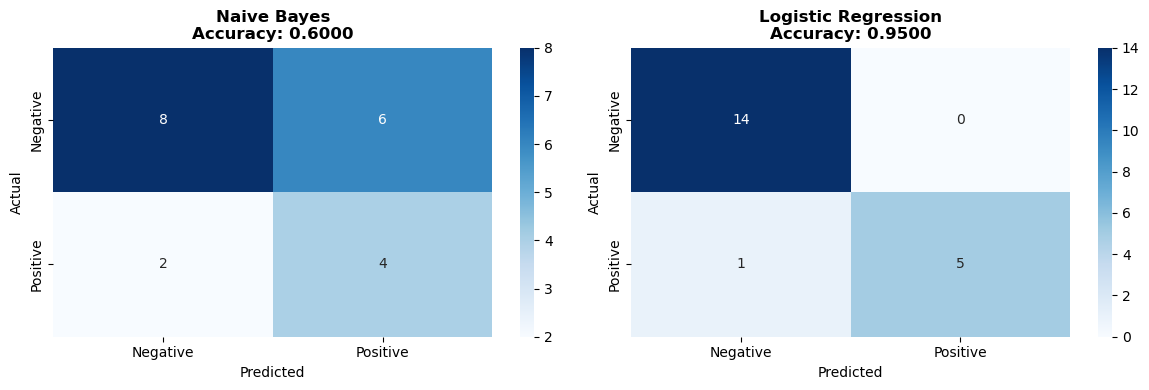


🔍 Misclassification Analysis — Logistic Regression (5 samples)

  [Sample 3]
    Text      : u just make everything paid trash app...
    True label: Positive
    Predicted : Negative
    VADER     : 0.000

  Total misclassified: 1 / 20 (5.0%)

  → Note: Labels derived from VADER compound score (threshold ≥ 0.05).
  → For production: replace with human-annotated star ratings as ground truth.


In [15]:
# ── 4️⃣ Baseline Sentiment Classification ─────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ── 1. Create labels from VADER compound score ────────────────────────────────
# Threshold: compound >= 0.05 → positive (1), else negative (0)
# This is a standard VADER heuristic for binary sentiment
df['sentiment_label'] = (df['vader_compound'] >= 0.05).astype(int)

label_counts = df['sentiment_label'].value_counts()
print("=" * 70)
print("📊 Sentiment Label Distribution (VADER threshold ≥ 0.05)")
print("=" * 70)
print(f"  Positive (1): {label_counts.get(1, 0):>4} reviews  ({label_counts.get(1,0)/len(df)*100:.1f}%)")
print(f"  Negative (0): {label_counts.get(0, 0):>4} reviews  ({label_counts.get(0,0)/len(df)*100:.1f}%)")

# ── 2. Build feature matrix ───────────────────────────────────────────────────
FEATURE_COLS = [
    'exclamation_count', 'question_count', 'repeated_punct', 'punct_intensity',
    'all_caps_ratio', 'negation_count', 'negation_context_len',
    'adjective_ratio', 'verb_ratio', 'adjective_count', 'verb_count',
    'emoji_count', 'text_length', 'word_count', 'lemma_count',
    'vader_positive', 'vader_negative', 'vader_neutral',
    'textblob_polarity', 'textblob_subjectivity',
]

X = df[FEATURE_COLS].fillna(0).values
y = df['sentiment_label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n  Train size : {len(X_train)}  |  Test size : {len(X_test)}")
print(f"  Features   : {len(FEATURE_COLS)}")

# ── 3. Scale features for Logistic Regression ────────────────────────────────
scaler  = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ── 4. Train classifiers ──────────────────────────────────────────────────────
models = {
    'Naive Bayes'        : GaussianNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
}

results = {}
for name, model in models.items():
    X_tr = X_train_scaled if name == 'Logistic Regression' else X_train
    X_te = X_test_scaled  if name == 'Logistic Regression' else X_test
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    results[name] = {'model': model, 'y_pred': y_pred, 'accuracy': accuracy_score(y_test, y_pred)}

# ── 5. Evaluation ─────────────────────────────────────────────────────────────
print("\n" + "=" * 70)
print("📋 Classification Results")
print("=" * 70)

for name, res in results.items():
    print(f"\n{'─' * 70}")
    print(f"  🤖 {name}   (Accuracy: {res['accuracy']:.4f})")
    print(f"{'─' * 70}")
    print(classification_report(y_test, res['y_pred'],
                                target_names=['Negative', 'Positive'],
                                zero_division=0))

# ── 6. Confusion matrices ─────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, (name, res) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    ax.set_title(f'{name}\nAccuracy: {res["accuracy"]:.4f}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.savefig('../Figures/baseline_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

# ── 7. Misclassification analysis ─────────────────────────────────────────────
print("\n" + "=" * 70)
print("🔍 Misclassification Analysis — Logistic Regression (5 samples)")
print("=" * 70)

lr_preds  = results['Logistic Regression']['y_pred']
test_idx  = df.index[int(len(df) * 0.8):]   # approximate test indices
misclassified = [
    i for i, (true, pred) in enumerate(zip(y_test, lr_preds)) if true != pred
]

for i in misclassified[:5]:
    approx_df_idx = int(len(df) * 0.8) + i
    if approx_df_idx < len(df):
        print(f"\n  [Sample {i}]")
        print(f"    Text      : {df['Content'].iloc[approx_df_idx][:70]}...")
        print(f"    True label: {'Positive' if y_test[i] == 1 else 'Negative'}")
        print(f"    Predicted : {'Positive' if lr_preds[i] == 1 else 'Negative'}")
        print(f"    VADER     : {df['vader_compound'].iloc[approx_df_idx]:.3f}")

print(f"\n  Total misclassified: {len(misclassified)} / {len(y_test)} ({len(misclassified)/len(y_test)*100:.1f}%)")
print("\n  → Note: Labels derived from VADER compound score (threshold ≥ 0.05).")
print("  → For production: replace with human-annotated star ratings as ground truth.")